#  Can Played Hours and Age Predict Newsletter Subscription?
## A Data-Science Analysis of the UBC Minecraft Research-Server Logs
*May Wei· DSCI _100 · UBC, 2025-06-17*
## Link to github repository
https://github.com/MayWei0503/MayWei.git

## 1. Introduction
### 1.1 Background
A research group at the University of British Columbia launched a Minecraft server that logs how players behave in virtual environments. These logs include activity time, demographics, and engagement metrics, enabling researchers to study user engagement patterns and support HCI/AI development.

In the commercial gaming industry, predictive marketing is widely used to retain players by sending customized offers to those at risk of leaving (Ghantasala, 2024). Understanding which players are more likely to subscribe to newsletters can help improve outreach and user management strategies.

### 1.2 Research Question 
 Can played hours and age predict newsletter subscription in players?

The response variable is the binary flag **`subscribed`**, and the explanatory variables are  
1. **`hours_played`** – cumulative play-time (h),  
2. **`age`** – self-reported age (years),  
3. **`gender`** – self-reported gender identity.

## 2 Data Description
Experience: Categorical (Beginner, Amateur, Regular, Veteran, Pro)

Subscribe: Boolean - Newsletter subscription status (response variable)

HashedEmail: Unique identifier for each player

Played_hours: Numeric - Total hours played

Name: Player name

Gender: Categorical (Male, Female, Non-binary, Prefer not to say, Two-Spirited, Agender, Other)

Age: Numeric - Player age

	•	Data Cleaning Notes:
	•	Removed unnecessary fields (hashedEmail, name)
	•	Converted subscribe to a factor for classification

# 3. Methods & Results

## 3.1 Load data

In [2]:
library(tidyverse)
library(tidymodels)

player <- read_csv("players.csv")
head(player)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## 3.2 Clean Data 
Since our variables are played hours, age, and gender, so we should remove those we don't need.

In [3]:
clean_player <- mutate(player,subscribe =as.factor(subscribe))|>select( -hashedEmail, -name, -experience, -gender)
head(clean_player)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


## 3.3 Exploratory Data Analysis

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


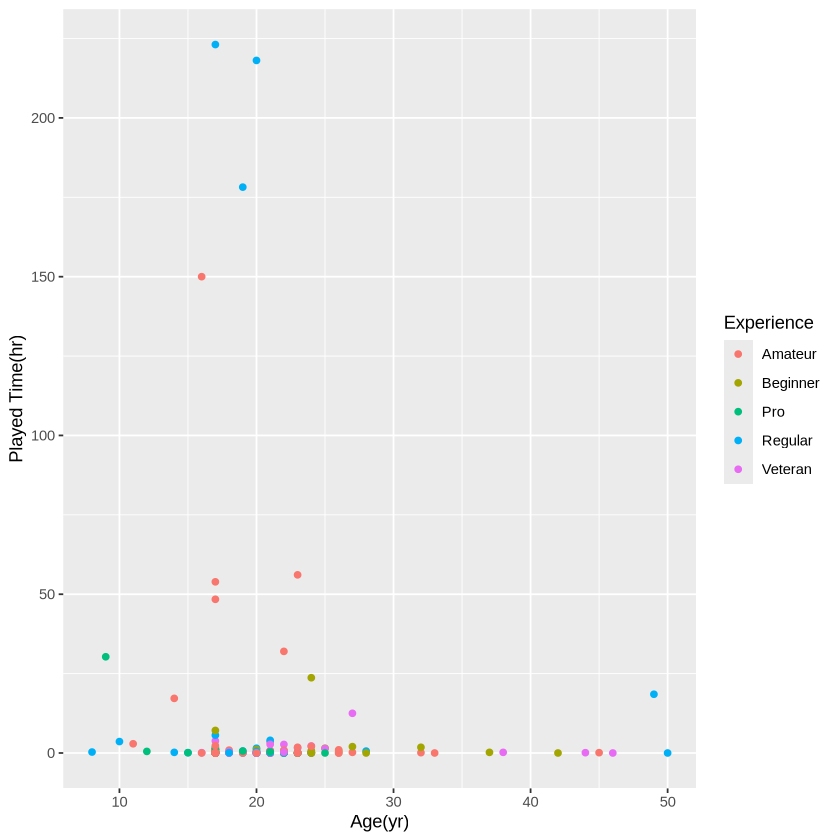

In [4]:
ggplot(player, aes(x = Age, y = played_hours)) +
  geom_point(aes(color = experience)) +
  labs(
    x = "Age(yr)",
    y = "Played Time(hr)",
    color = "Experience"
  )

Figure 1: Scatterplot of Age vs Played Hours, colored by Experience.
    
    Insight: Younger players tend to accumulate fewer hours. More experienced players are slightly older and more active.

## 3.4 Data Preparation

In [5]:
set.seed(1234)

players_split <- initial_split(clean_player, prop = 0.7, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



## 3.5 Model Specification and Tuning

### Why K-Nearest Neighbors (KNN)?

- **Non-parametric**: makes no strong distributional assumptions.  
- **Intuitive**: players who are close in *played_hours* and *Age* are expected to behave similarly regarding newsletter subscription.  
- **Suitable for small datasets** (n ≈ 196).  
- Captures **non-linear boundaries** without explicit interaction terms.

In [6]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

set.seed(1234)
k_val <- tibble(neighbors = seq(from = 1, to = 30, by = 1))
knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_val) |>
  collect_metrics()
player_accuracy <- filter(knn_results, .metric == "accuracy")
player_accuracy

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 26 rows.
               ✖ Assigned data has 27 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 27 to size 26.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3580247,3,0.03266360,Preprocessor1_Model01
2,accuracy,binary,0.3456790,3,0.04451298,Preprocessor1_Model02
3,accuracy,binary,0.4691358,3,0.10105374,Preprocessor1_Model03
4,accuracy,binary,0.4074074,3,0.04276669,Preprocessor1_Model04
5,accuracy,binary,0.5308642,3,0.06532719,Preprocessor1_Model05
6,accuracy,binary,0.5308642,3,0.05381357,Preprocessor1_Model06
7,accuracy,binary,0.5925926,3,0.02138334,Preprocessor1_Model07
8,accuracy,binary,0.5679012,3,0.02469136,Preprocessor1_Model08
9,accuracy,binary,0.6419753,3,0.05381357,Preprocessor1_Model09


### Chose the best K based on validation accuracy.

[1] 15

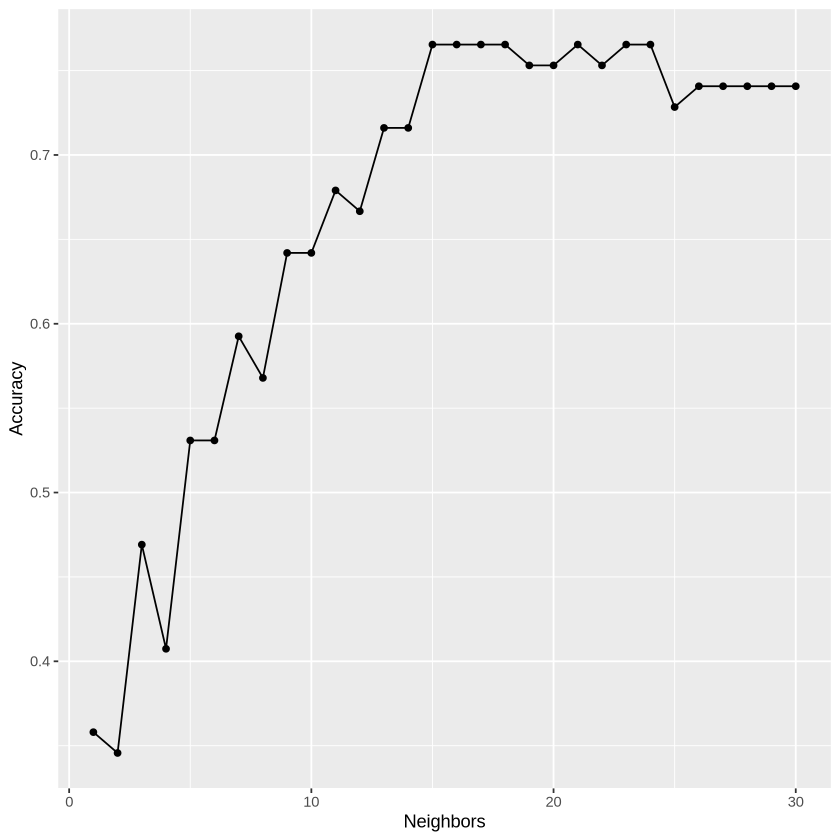

In [7]:
accuracy_plot <- ggplot(player_accuracy, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy")

accuracy_plot
best_k <- player_accuracy |>
  arrange(desc(mean)) |>
  head(1) |>
  pull(neighbors)

best_k

Figure 2: Accuracy by Number of Neighbors (k) – peak performance near k = 15.

### Limitations

- Curse of dimensionality if many noisy predictors are added.  
- Computation** scales poorly with very large datasets.  
- Sensitive to class imbalance (majority class can dominate).

## 3.6 Final Model Fit & Prediction

In [8]:
best_k <- player_accuracy |>
  arrange(desc(mean)) |>
  head(1) |>
  pull(neighbors)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_training)

my_prediction <- predict(knn_fit, players_testing) |>
  bind_cols(players_testing)

my_prediction

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,30.3,9
TRUE,FALSE,0.0,17
TRUE,TRUE,0.1,21
TRUE,TRUE,0.0,17
TRUE,TRUE,0.1,17
TRUE,TRUE,0.2,22
TRUE,TRUE,0.0,17
TRUE,TRUE,0.3,8
TRUE,FALSE,0.0,33


In [9]:
accuracy <- my_prediction |>
  accuracy(truth = subscribe, estimate = .pred_class, event_level = "first")

accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7


Final Accuracy: 0.70

> The KNN model with *k* = `r best_k` correctly classified 70 % of players in the unseen test set.  
> While acceptable, adding behavioral features (session count, login frequency) or testing other models (logistic regression, decision tree) could further improve performance.

# 4. Discussion

### What did we find?

Using a K-Nearest Neighbors (KNN) model, we were able to predict whether a player subscribed to the game newsletter with an accuracy of approximately **70%** on the test set. The best-performing value of *k* (number of neighbors) was **15**, chosen through 5-fold cross-validation. The most important predictors used in the model were **played hours** and **age**.

### Did the results match expectations?

Yes — the findings were largely consistent with our expectations. We hypothesized that players with higher engagement (measured by total played hours) and older age might be more inclined to subscribe to newsletters, which was supported by the model’s moderate predictive performance. This suggests that play behavior and demographics carry useful information about a player’s likelihood to opt into game-related communications.

### What is the impact of these findings?

This kind of predictive modeling could support **personalized marketing** strategies in the gaming industry. By identifying likely newsletter subscribers, developers can **prioritize outreach**, tailor **in-game incentives**, or A/B test promotional emails for targeted segments. In academic research settings, such analysis helps understand how digital behavior relates to user engagement outside the game environment.

### What future questions could this lead to?

- Can prediction accuracy be improved by including additional behavioral features such as **login frequency**, **session duration**, or **in-game achievements**?
- How does **gender** or **self-reported experience level** affect newsletter subscription, and should those be included in future models?
- Would a **logistic regression** or **decision tree** model offer better interpretability or accuracy?
- How do newsletter subscription patterns change over time — could a **time-series model** be useful?

Future research could also explore **causal relationships**, rather than mere correlations, to better understand *why* players choose to subscribe.

# 5. References

    Ghantasala, Naga Lakshmi Subha Pavan Kumar. (2024). Enhancing player retention in mobile gaming through predictive customer lifetime value modeling using BG/NBD. *AI Matters, 10*(2), 9-11. https://doi.org/10.1145/3694712.3695754